In [210]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pywt
import re

In [8]:
#  Parameters of the paper:

K = 2
# lambda_k = 1/k
# tau_k = sigma*lambda_k/4
N1 = 10
N2 = 32

## Block Matching

### Extracting patches

In [74]:
img = plt.imread('input.png')
print(img.shape)

(518, 774, 3)
51


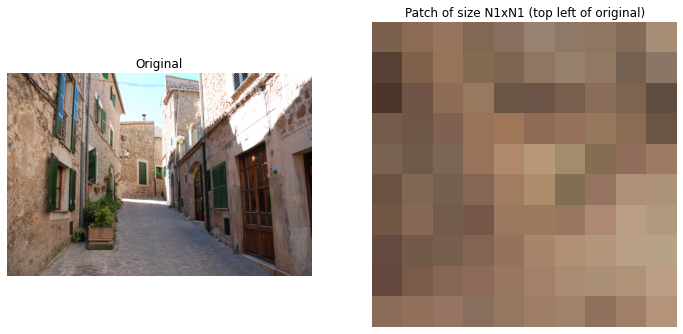

In [65]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(img[:10,:10,:])
plt.axis('off')
plt.title('Patch of size N1xN1 (top left of original)')

plt.show()

In [84]:
# Choix des patchs: pas de overlapp sauf dans les coins (ceci pour éviter une quantité trop grandes de patchs pour la matrice de similarité)

def dividing_into_patches(img):
    n, p = img.shape[0], img.shape[1]
    patches = []
    n_10, p_10 = n//10, p//10
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                patches.append(img[i*N1:i*N1+10, j*N1:j*N1+10, :])
            elif i == n_10 and j < p_10:
                patches.append(img[n-10:n, j*N1:j*N1+10, :])
            elif i < n_10 and j == p_10:
                patches.append(img[i*N1:i*N1+10, p-10:p, :])
            elif i == n_10 and j == p_10:
                patches.append(img[n-10:n, p-10:p, :])
    return np.array(patches)       

In [88]:
patches = dividing_into_patches(img)
print('There are: ' + str(patches.shape[0]) + ' patches in this image (N = (n//10+1)*(p//10+1))')

There are: 4056 patches in this image (N = (n//10+1)*(p//10+1))


### Similarity Matrix

In [235]:
def similarity_matrix(img):
    patches = dividing_into_patches(img)
    size = patches.shape[0]
    similarity = np.zeros((size,size))
    sim = 0

    # similarity computed with the Frobenius norm
    # leave the 0 similarity with itself to make sure every patch will be in S
    for i in range(size):
        for j in range(size):
            sim = np.linalg.norm(patches[i] - patches[j])
            similarity[i][j] = sim
    return similarity    

In [236]:
similarity = similarity_matrix(img)
print(similarity)

[[0.         2.60369134 2.32931948 ... 3.10237741 3.11118841 3.07988977]
 [2.60369134 0.         2.39025974 ... 3.58760977 3.6318109  3.53523064]
 [2.32931948 2.39025974 0.         ... 2.66134715 2.69916487 2.54908919]
 ...
 [3.10237741 3.58760977 2.66134715 ... 0.         0.66837156 0.6209715 ]
 [3.11118841 3.6318109  2.69916487 ... 0.66837156 0.         0.69177628]
 [3.07988977 3.53523064 2.54908919 ... 0.6209715  0.69177628 0.        ]]


In [237]:
def building_the_look_up_table(similarity):
    S = {}
    n = similarity.shape[0]
    for i in range(n):
        idx = np.argpartition(similarity[i], N2)
        S['patch ' + str(i)] = idx[:N2]
    return S

In [238]:
look_up_table = building_the_look_up_table(similarity)
print(look_up_table['patch 0'])

[1861    0 3286 3986 3442 3050 3043 3670 3748 3278 3515 3282 3207 3283
 2970 2825 3288 2974 3361 1783 3363  933 2084 1470 3364 2361 2240 2162
 1694 1772 3750 2730]


## Separating RBG

In [179]:
red = patches[:,:,:,0]
blue = patches[:,:,:,1]
green = patches[:,:,:,2]

In [107]:
print(red.shape)

(4056, 10, 10)


## NLF Filter

In [148]:
def building_gkj_array(patch_ind, look_up_table, patches):
    gkj = np.zeros((N1,N1,N2))
    idx = look_up_table['patch ' + str(patch_ind)]
    for i in range(len(idx)):
        gkj[:,:,i] = patches[idx[i]]
    return gkj

In [150]:
print(building_gkj_array(1, look_up_table, red).shape)

(10, 10, 32)


### Wavelet Function Python

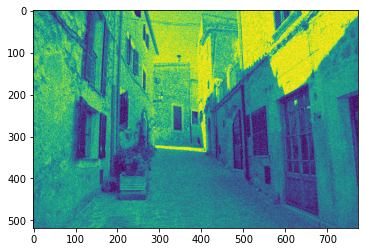

In [172]:
noisy_img = plt.imread('noisy.png')
red_noise = noisy_img[:,:,0]
plt.imshow(red_noise)

In [152]:
pywt.families()  # use Haar wavelet

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

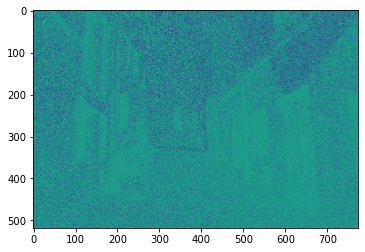

In [168]:
wavelet = pywt.Wavelet('haar')
a, b = pywt.dwt(red_noise, 'haar')
y = pywt.idwt(a, b, 'haar')
plt.imshow(y-red_noise)

### Article's Transform

In [181]:
def Gamma(q, tau):
    return q**3/(q**2+tau**2)

In [184]:
#sigma = 30, 50, 75

def transform_haar_wavelet(patch_ind,patches,k,sigma):
    tau_k = (1/4)*sigma/k
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
    gam_a_k = Gamma(a_k, tau_k)
    gam_b_k = Gamma(b_k, tau_k)
    gkj_hat = pywt.idwt(gam_a_k,gam_b_k, 'haar')
    return gkj_hat

In [189]:
print(transform_haar_wavelet(1,red,1,30).shape)

(10, 10, 32)


In [190]:
def transform_over_all_img(look_up_table,patches,k,sigma):
    n = patches.shape[0]
    transform = []
    for i in range(n):
        gkj_tilde = building_gkj_array(i, look_up_table, patches)
        gkj_hat = transform_haar_wavelet(i,patches,k,sigma)
        transform.append(gkj_hat)
    return np.array(transform)

In [195]:
k = 1
sigma = 30
transform_red = transform_over_all_img(look_up_table,red,k,sigma)
transform_blue = transform_over_all_img(look_up_table,blue,k,sigma)
transform_green = transform_over_all_img(look_up_table,green,k,sigma)
print(transform_red.shape)

(4056, 10, 10, 32)


### Image Estimate

In [201]:
def weight_j(patch_ind, look_up_table, patches, tau):
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches)
    a_k, b_k = pywt.dwt(gkj_tilde, 'haar')
    wkj = (np.linalg.norm(a_k**2/(a_k**2+tau**2)) + np.linalg.norm(b_k**2/(b_k**2+tau**2)))**(-2)
    return wkj

In [202]:
print(weight_j(1, look_up_table, red, 7.5))

4.968464728370477


In [198]:
def all_weights(look_up_table, patches, tau):
    n = patches.shape[0]
    w = []
    for i in range(n):
        w.append(weight_j(i, look_up_table, patches, tau))
    return w

In [200]:
print(len(all_weights(look_up_table, red, 7.5)))

4056


In [242]:
def inverse_look_up_table(patches, look_up_table):
    inv = {}
    n = patches.shape[0]
    for i in range(n):
        for patch in look_up_table:
            if i in look_up_table[patch]:
                if ('patch '+str(i)) in inv.keys():
                    inv['patch '+str(i)] += [int(re.findall(r'\d+', patch)[0])]
                else: 
                    inv['patch '+str(i)] = [int(re.findall(r'\d+', patch)[0])]
    return inv

In [243]:
inv = inverse_look_up_table(patches, look_up_table)
print(len(inv))

4056


In [247]:
def new_patches(look_up_table, inv, patches, tau, img):
    weights = all_weights(look_up_table, patches, tau)
    n, p = img.shape[0], img.shape[1]
    new_patches = []
    n_cpt, p_cpt = 0, 0
    for patch in inv:
        summing = np.zeros((N1,N1))
        for pat in inv[patch]:
            summing += weights[pat]*patches[pat]
        new_patches.append(summing)
    return np.array(new_patches)

In [274]:
new_patch = new_patches(look_up_table, inv, red, 7.5, img)

In [278]:
def image_estimate(new_patches, img):
    n, p = img.shape[0], img.shape[1]
    new_image = np.zeros((n, p))
    n_10, p_10 = n//10, p//10
    cpt = 0
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                new_image[i*N1:i*N1+N1, j*N1:j*N1+N1] = new_patches[cpt]
            elif i == n_10 and j < p_10:
                new_image[i*N1:n, j*N1:j*N1+N1] = new_patches[cpt][N1-(n-i*N1):,:]
            elif i < n_10 and j == p_10:
                new_image[i*N1:i*N1+N1, j*N1:p] = new_patches[cpt][:,N1-(p-j*N1):]
            elif i == n_10 and j == p_10:
                new_image[i*N1:n, j*N1:p] = new_patches[cpt][N1-(n-i*N1):,N1-(p-j*N1):]
        cpt += 1
    return new_image

In [279]:
img_est = image_estimate(new_patch, img)

In [280]:
print(img_est)

[[22.61242074 21.75951028 23.3421663  ... 30.48993087 30.62425399
  27.92340422]
 [18.62356138 21.38036573 23.66685033 ... 30.13194323 29.19834042
  25.68907642]
 [19.09246874 22.45864832 21.5701642  ... 29.04504442 28.46969271
  21.04375291]
 ...
 [16.13421386 17.12572426 17.52696234 ... 18.23702535 18.56134838
  18.67497408]
 [16.61943021 17.38776705 17.82291403 ... 18.19483638 18.4695338
  18.60515881]
 [17.00409073 17.37359306 18.10097092 ... 18.08167559 18.46573704
  18.71649668]]
